# Staffing Optimization: 24-Hour Operations Model
his model optimizes staffing across 6 distinct time blocks to minimize total headcount while meeting fluctuating demand. Each employee works a continuous 8-hour shift (covering two consecutive blocks).

| Shift Block | Shift Start | Shift End | Period Type      |
| ---------- | ----------- | --------- | ---------------- |
| 1          | 06.00       | 10.00     | Breakfast Rush   |                 
| 2          | 10.00       | 14.00     | Lunch Peak       |                 
| 3          | 14.00       | 18.00     | Afternoon Lull   |                 
| 4          | 18.00       | 22.00     | Dinner Rush      |                 
| 5          | 22.00       | 02.00     | Late Night Crowd | 
| 6          | 02.00       | 06.00     | Overnight / Prep | 

In [16]:
import pandas as pd

data_dir = '../data'

# ============================================
# 1. Load your data
# ============================================
demand_df = pd.read_excel(f'{data_dir}/demand.xlsx')
demands = demand_df['Staff Req'].tolist() # List of requirements [12, 20, 6, 18, 10, 4]
demand_df


,Shift Block,Shift Start,Shift End,Period,Typical Activity,Staff Req,Kitchen Req,Service Req
0,1,06:00:00,10:00:00,6:00 AM – 10:00 AM,Breakfast Rush,12,8,4
1,2,10:00:00,14:00:00,10:00 AM – 2:00 PM,Lunch Peak,20,14,6
2,3,14:00:00,18:00:00,2:00 PM – 6:00 PM,Afternoon Lull,8,6,2
3,4,18:00:00,22:00:00,6:00 PM – 10:00 PM,Dinner Rush,18,14,4
4,5,22:00:00,02:00:00,10:00 PM – 2:00 AM,Late Night Crowd,11,7,4
5,6,02:00:00,06:00:00,2:00 AM – 6:00 AM,Overnight/Prep,6,4,2


In [17]:
# ============================================
# 2. Define the Linear Programming Problem
# ============================================
import pulp
prob = pulp.LpProblem("Optimal_Staffing", pulp.LpMinimize)

## The Sets and Variables (The Starting Times):

**Set(s):** 

set $T$ for shift block. 

**Decision Variables:**
Let $k_t$ and $s_t$ be integer decision variables representing staff starting at period $t$.
Example:
- $k_{1}$ : number of required kitchen staff at Shift Block 1 (06.00-10.00)
- $s_{2}$ : number of required kitchen staff at Shift Block 1 (10.00-14.00)


In [18]:
# 3. Define Decision Variables
# x[i] is the number of people starting their 8-hour shift at the beginning of Period i
# These must be Integers (cat='Integer') and non-negative (lowBound=0)

x = pulp.LpVariable.dicts("Shift_Start", range(0, 6), lowBound=0, cat='Integer')

## The Objective
Minimize the total number of people for both line (kitchen line and service line):
$$\text{Minimize } Z = \sum_{t \in T}k_t + \sum_{t \in T}s_t $$

In [19]:
# ============================================
# 4. Objective Function
# ============================================
# Minimize the sum of all people starting shifts

prob += pulp.lpSum([x[i] for i in range(6)]), "Total_Staff"

## The Overlapping Constraints
Because each person works 8 hours, the staff present in Period 2 is the sum of people who started in Period 1 and those who just started in Period 2.
- 6 AM – 10 AM: $k_6 + k_1 \geq 8$
- 10 AM – 2 PM: $k_1 + k_2 \geq 14$
- 2 PM – 6 PM: $k_2 + k_3 \geq 6$
- 6 PM – 10 PM: $k_3 + k_4 \geq 14$
- 10 PM – 2 AM: $k_4 + k_5 \geq 7$
- 2 AM – 6 AM: $k_5 + k_6 \geq 4$

In [20]:
# ============================================
# 5. Adding Constraints (The Overlap Logic)
# ============================================

# Each person works two consecutive periods. 
# Period t is covered by people starting in Period t AND Period t-1.

for i in range(6):
    # The (i-1)%6 handles the "wrap-around" (the 2 AM shift covers 6 AM)
    prob += x[i] + x[(i-1) % 6] >= demands[i], f"Constraint_Period_{i+1}"


In [21]:
# ============================================
# 6. Solve the problem
# ============================================
prob.solve()

# ============================================
# 7. Print the Results
#
print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Minimum Total Staff Needed: {pulp.value(prob.objective)}")

for i in range(6):
    print(f"Staff starting at {demand_df['Period'].iloc[i]}: {x[i].varValue}")

Status: Optimal
Minimum Total Staff Needed: 44.0
Staff starting at 6:00 AM – 10:00 AM: 6.0
Staff starting at 10:00 AM – 2:00 PM: 14.0
Staff starting at 2:00 PM – 6:00 PM: 0.0
Staff starting at 6:00 PM – 10:00 PM: 18.0
Staff starting at 10:00 PM – 2:00 AM: 0.0
Staff starting at 2:00 AM – 6:00 AM: 6.0


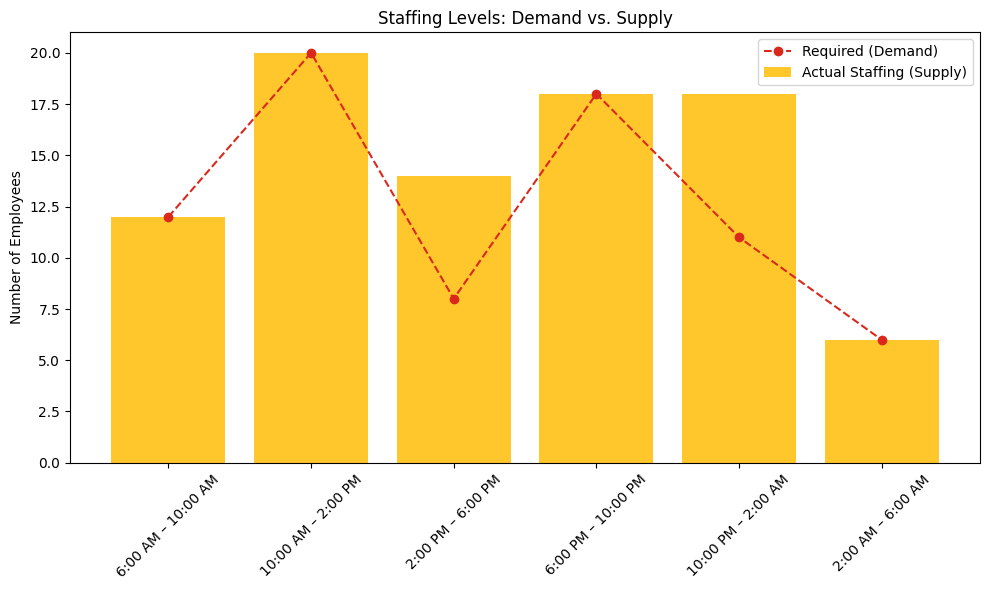

In [22]:
import matplotlib.pyplot as plt
import os

# 1. Setup
result_dir = '../result/1. single_line'

# Brand Colors
MCD_RED = '#DA291C'
MCD_YELLOW = '#FFC72C'
MCD_BLACK = '#27251F'


# Data Preparation
periods = demand_df['Period'].tolist()
required = demands
# Calculate actual staff per period: x[i] + x[i-1]
actual = [pulp.value(x[i] + x[(i-1)%6]) for i in range(6)]

plt.figure(figsize=(10, 6))
plt.plot(periods, required, label='Required (Demand)', marker='o', linestyle='--', color=MCD_RED)
plt.bar(periods, actual, label='Actual Staffing (Supply)', color=MCD_YELLOW)

plt.title('Staffing Levels: Demand vs. Supply')
plt.xticks(rotation=45)
plt.ylabel('Number of Employees')
plt.legend()
plt.tight_layout()

plt.savefig(f'{result_dir}/demand_vs_supply.png')
plt.show()

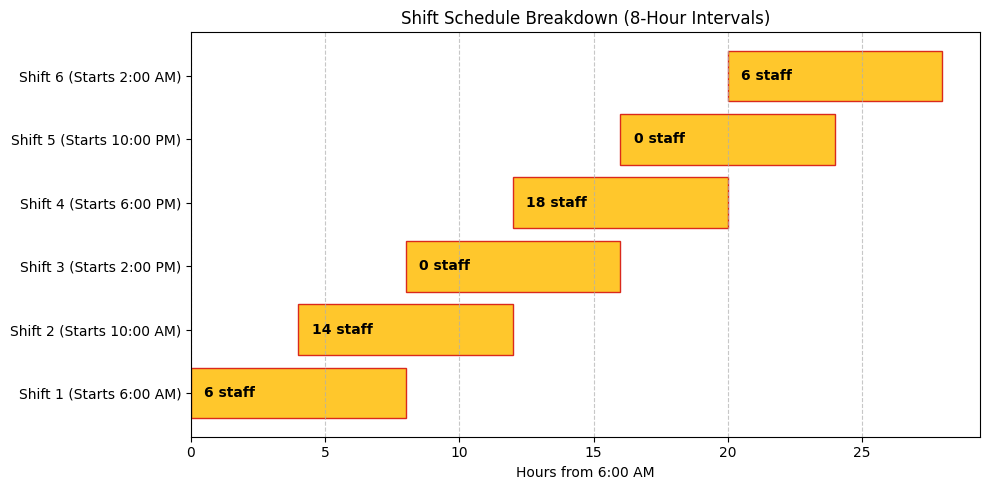

In [23]:
plt.figure(figsize=(10, 5))
for i in range(6):
    start = i * 4  # Each period is 4 hours
    # Each shift lasts 8 hours
    plt.barh(y=f"Shift {i+1} (Starts {periods[i].split(' – ')[0]})", 
             width=8, left=start, color=MCD_YELLOW, edgecolor=MCD_RED)
    plt.text(start + 0.5, i, f"{int(x[i].varValue)} staff", va='center', fontweight='bold')

plt.xlabel('Hours from 6:00 AM')
plt.title('Shift Schedule Breakdown (8-Hour Intervals)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig(f'{result_dir}/shift_gantt.png')
plt.show()